In [1]:
from wd_functions import *

Import data

In [2]:
df = pd.read_pickle('../../exp_data/DFallDiscsIncreaselimitcounts.pkl')

In [3]:
#genotype = 'ecadGFPnbG4'
#df = df[df['genotype'] == genotype]

devstage_map = {
                "96hAEL":"96hAEL",
                "120hAEL":"120hAEL",
                "upcrawling":"wL3",
                "whitePupa":"0hAPF",
                "2hAPF":"2hAPF",
                "4hAPF":"4hAPF",
                "6hAPF":"6hAPF",
               }
df["devstage"] = [devstage_map[x] for x in df["devstage"].values]

### Select one disc

In [4]:
devstage = "wL3"
genotype = 'ecadGFPnbG4'
seed = 1#42#3#
#np.random.seed(seed)
#disc = np.random.choice(df.query(f"devstage == \"{devstage}\" and genotype == \"{genotype}\" ")["disc"])
#discs = np.unique(df.query(f"devstage == \"{devstage}\" and genotype == \"{genotype}\" ")["disc"])
discs = np.unique(df.query(f"devstage == \"{devstage}\" ")["disc"])
disc = discs[0]
disc = '20210706_ecadGFPnbG4_upcrawling_disc3_1'
disc_df = df.query(f"disc == \"{disc}\" ")
#here we group by discName because we want to have the scaling in DV and outDV region differently
disc_df["k_dist_pathlength_scaled"] = disc_df[["discName", "k_dist_pathlength"]].groupby("discName").transform(lambda col: col/max(col))
#adding an int for DV region and outDV
disc_df["DV_bool"] = np.where(disc_df["region"] == "DV", 1, 0)
#making a copy of the original positions of the points
disc_df[["center_x_orig", "center_y_orig", "center_z_orig"]] = disc_df[["center_x", "center_y", "center_z"]]

Separate disc into DV, outDV. Also get k = 0 line in DV.

In [5]:
disc_DV = disc_df.query('region == "DV"')
disc_outDV = disc_df.query('region == "outDV"')
center_DV = disc_DV.query('k_dist == 0')

### Plot original disc

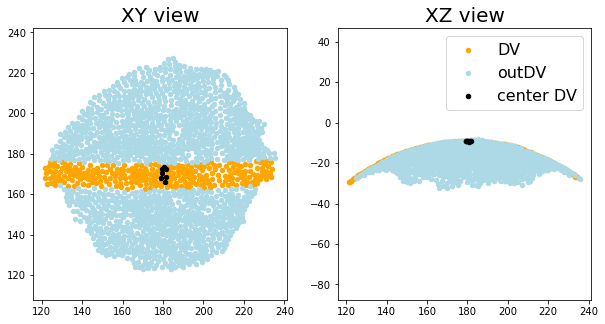

In [6]:
%matplotlib inline
s = 20

fig,axs = plt.subplots(1,2,figsize = (10,5))

ax = axs[0]
ax.scatter(disc_DV["center_x"],disc_DV["center_y"], label = "DV",s = s, color = "orange")
ax.scatter(disc_outDV["center_x"],disc_outDV["center_y"], label = "outDV",s = s, color = "lightblue")
ax.scatter(center_DV["center_x"],center_DV["center_y"], label = "center DV",s = s, color = "black")
ax.axis("equal")
ax.set_title("XY view", fontsize = 20)

ax = axs[1]
ax.scatter(disc_DV["center_x"],disc_DV["center_z"], label = "DV",s = s, color = "orange")
ax.scatter(disc_outDV["center_x"],disc_outDV["center_z"], label = "outDV",s = s, color = "lightblue")
ax.scatter(center_DV["center_x"],center_DV["center_z"], label = "center DV",s = s, color = "black")
ax.axis("equal")
ax.legend(fontsize = 16)
ax.set_title("XZ view", fontsize = 20)

os.makedirs("plots/", exist_ok=True)
fig.savefig("plots/orig_"+disc_df.iloc[0]["disc"]+".pdf", bbox_inches = "tight")

### Rescale disc to match simulation lengthscales

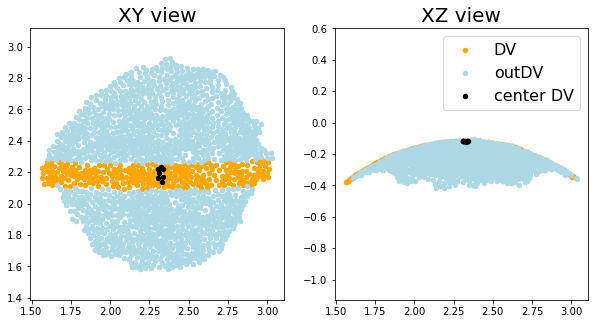

In [7]:
%matplotlib inline
#we scale it down by the average radius of curvature at wL3 stage which we have already computed earlier
#one can scale it by the average mean curvature as well but then we need to remember the scale while rescaling it
scale = 77.66

disc_df[["center_x", "center_y", "center_z"]] = disc_df[["center_x_orig", "center_y_orig", "center_z_orig"]]/scale

#replotting them 
#we expect the x-y span to be about 1.4 units

disc_DV = disc_df.query('region == "DV"')
disc_outDV = disc_df.query('region == "outDV"')
center_DV = disc_DV.query('k_dist == 0')

fig,axs = plt.subplots(1,2,figsize = (10,5))

ax = axs[0]
ax.scatter(disc_DV["center_x"],disc_DV["center_y"], label = "DV",s = s, color = "orange")
ax.scatter(disc_outDV["center_x"],disc_outDV["center_y"], label = "outDV",s = s, color = "lightblue")
ax.scatter(center_DV["center_x"],center_DV["center_y"], label = "center DV",s = s, color = "black")
ax.axis("equal")
ax.set_title("XY view", fontsize = 20)

ax = axs[1]
ax.scatter(disc_DV["center_x"],disc_DV["center_z"], label = "DV",s = s, color = "orange")
ax.scatter(disc_outDV["center_x"],disc_outDV["center_z"], label = "outDV",s = s, color = "lightblue")
ax.scatter(center_DV["center_x"],center_DV["center_z"], label = "center DV",s = s, color = "black")
ax.axis("equal")
ax.legend(fontsize = 16)
ax.set_title("XZ view", fontsize = 20)
fig.savefig("plots/scaled_to_sim_"+disc_df.iloc[0]["disc"]+".pdf", bbox_inches = "tight")

### Reorient discs to align with x,y,z axis

To reorient discs, we 
1. compute a unit vector going through the k = 0 points in the DV boundary ($\underline{e}^{DVc}_{\phi}$)
2. compute an average normal vector for all the k = 0 points in the DV boundary ($\underline{n}_{k = 0}$)
3. Take a projection of that normal vector in the direction perpendicular to $\underline{e}^{DVc}_{\phi}$ ($\underline{e}^{DVc}_{h}$)
4. Rotate the frame so that in the rotated frame, $\underline{e}'_{x} = \underline{e}^{DVc}_{\phi}$, $\underline{e}'_{y} = \underline{e}^{DVc}_{R}$ and $\underline{e}'_{z} = \underline{e}^{DVc}_{h}$
5. Compute a point in the center of the k = 0 line in DV boundary ($DVc$) (Here take a projection of all k=0 points on the line $\underline{e}^{DVc}_{\phi}$ and find the most extreme values of the parameter $t$) (line.point returns the centroid of the line)
6. Translate $DVc$ to a reference point (0,0,1)

In [9]:
#1. compute a unit vector going through the k = 0 points in the DV boundary ($e^{DVc}_{\phi}$)
from skspatial.objects import Line
points = center_DV[["center_x", "center_y", "center_z"]].values
line_DVc = Line.best_fit(points)
e_DVc_phi = line_DVc.direction.unit() #how are we deciding the direction?

#2. compute an average normal vector for all the k = 0 points in the DV boundary ($n_{k = 0}$)
avg_normal = center_DV[["normal_x","normal_y", "normal_z"]].values.mean(axis = 0)

Defining $e^{DVc}_{h}$

$\underline{n}_{k=0}=\left(\underline{n}_{k=0} \cdot \underline{e}_\phi^{D Vc}\right) \underline{e}_\phi^{D Vc}+A \underline{e}_h^{D Vc}$ 

$A \underline{e}_{h}^{D Vc}=\underline{n}_{k=0}-\left(\underline{n}_{k=0} \cdot \underline{e}_\phi^{D Vc}\right) \underline{e}_\phi^{D Vc}$ 

$e_h^{D V_c}=\frac{\underline{n}_{k=0}-\left(\underline{n}_{k=0} \cdot \underline{e}_\phi^{D Vc}\right) \underline{e}_\phi^{D Vc}}{A}$


Here A is the norm of $e_h^{D V_c}$

In [10]:
#3. Take a projection of that normal vector in the direction perpendicular to $e^{DVc}_{\phi}$ ($e^{DVc}_{h}$)
e_DVc_h = (avg_normal - (np.dot(e_DVc_phi, avg_normal))*e_DVc_phi).unit()
#e_DVc_h.is_perpendicular(e_DVc_phi) result True
e_DVc_R = e_DVc_phi.cross(e_DVc_h)#np.cross(e_DVc_phi, e_DVc_h)

In [11]:
#4. Rotate the frame so that in the rotated frame, $e'_{x} = e^{DVc}_{\phi}$ and $e'_{z} = e^{DVc}_{h}$#

def rotate_frame(points,
                 e_x_rot = [0,0,1], e_y_rot = [0,1,0], e_z_rot = [-1,0,0],
                 e_x = [1,0,0], e_y = [0,1,0],e_z = [0,0,1]
                ):
    #points : a matrix of shape (nb_points, 3)
    #e_x, e_y, e_z are the original basis unit vectors 
    #e_x_rot, e_y_rot, e_z_rot are the new basis unit vectors
    
    #to test let's say 
    #e_x_rot = [0,0,1]
    #e_y_rot = [0,1,0]
    #e_z_rot = [-1,0,0]
    #points = np.array([[0,0,1], #a point on the z axis which should be on new x axis after rotation 
    #                   [-1,0,0]]) # a point on negative x axis should be on z axis after rotation
    #points_rot = rotate_frame(points,e_x_rot,e_y_rot,e_z_rot,e_x = [1,0,0], e_y = [0,1,0],e_z = [0,0,1])
    ## expected value: 
    ## [[1,0,0],
    ##  [0,0,1]]

    #Rotation matrix conditions : transpose = inverse and determinant = 1
    R = np.matrix([[np.dot(e_x, e_x_rot), np.dot(e_y,e_x_rot),np.dot(e_z,e_x_rot)],
         [np.dot(e_x,e_y_rot),np.dot(e_y,e_y_rot),np.dot(e_z,e_y_rot)],
         [np.dot(e_x,e_z_rot),np.dot(e_y,e_z_rot),np.dot(e_z,e_z_rot)]
        ])
    
    points_rot = np.matmul(R, points.T).T
    
    return(points_rot)


#disc_df[["center_x_before_rotation", "center_y_before_rotation", "center_z_before_rotation"]] = disc_df[["center_x", "center_y", "center_z"]]
disc_df[["center_x", "center_y", "center_z"]] = rotate_frame(points = disc_df[["center_x", "center_y", "center_z"]].values,
                                                             e_x_rot = e_DVc_phi, e_y_rot = e_DVc_R, e_z_rot = e_DVc_h
                                                            )
disc_df[['normal_x', 'normal_y', 'normal_z']] = rotate_frame(points = disc_df[['normal_x', 'normal_y', 'normal_z']].values,
                                                             e_x_rot = e_DVc_phi, e_y_rot = e_DVc_R, e_z_rot = e_DVc_h
                                                            )
disc_df[['rHat_geom_inPlane_x', 'rHat_geom_inPlane_y', 'rHat_geom_inPlane_z']] = rotate_frame(points = disc_df[['rHat_geom_inPlane_x', 'rHat_geom_inPlane_y', 'rHat_geom_inPlane_z']].values,
                                                             e_x_rot = e_DVc_phi, e_y_rot = e_DVc_R, e_z_rot = e_DVc_h
                                                            )

In [12]:

#Next we refit a line going through DV
disc_DV = disc_df.query('region == "DV"')
disc_outDV = disc_df.query('region == "outDV"')
center_DV = disc_DV.query('k_dist == 0')
line_DVc = Line.best_fit(center_DV[["center_x", "center_y", "center_z"]].values)

#5. Compute a point in the center of the k = 0 line in DV boundary ($DVc$)
#line.point returns the centroid of the line
point_DVc = line_DVc.point

#6. Translate $DVc$ to a reference point (0,0,1)
disc_df[["center_x", "center_y", "center_z"]] = disc_df[["center_x", "center_y", "center_z"]] - point_DVc + np.array([0,0,1])

#Refit the line going through DV
center_DV = disc_DV.query('k_dist == 0')
line_DVc = Line.best_fit(center_DV[["center_x", "center_y", "center_z"]].values)

# Define the basis vectors again 
from skspatial.objects import Vector
e_DVc_phi = Vector.from_points([0, 0, 0], [1, 0, 0]) #x axis
e_DVc_R = Vector.from_points([0, 0, 0], [0, 1, 0]) #y axis
e_DVc_h = Vector.from_points([0, 0, 0], [0, 0, 1]) #z axis

In [13]:
#for now
#disc_df["center_z"] = disc_df["center_z"]*-1 + 2

### Compare disc and spherical mesh

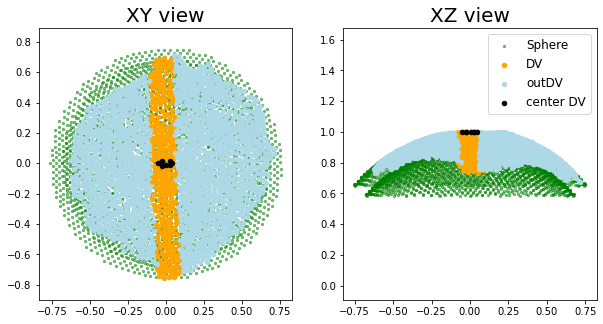

In [14]:
import pyvista as pv
mesh = pv.read('thick_meshes/k_c_thickness_0.1_0.vtk') 

disc_DV = disc_df.query('region == "DV"')
disc_outDV = disc_df.query('region == "outDV"')
center_DV = disc_DV.query('k_dist == 0')

fig,axs = plt.subplots(1,2,figsize = (10,5))

ax = axs[0]
ax.scatter(mesh.points[:,0], mesh.points[:,1], alpha = 0.5, s = 5, color = "green")
ax.scatter(disc_DV["center_x"],disc_DV["center_y"], label = "DV", s = s, color = "orange")
ax.scatter(disc_outDV["center_x"],disc_outDV["center_y"], label = "outDV", s = s, color = "lightblue")
ax.scatter(center_DV["center_x"],center_DV["center_y"], label = "center DV", s = s, color = "black")
#ax.scatter(point_DVc[0],point_DVc[1], color = "black")
ax.axis("equal")
ax.set_title("XY view", fontsize = 20)

ax = axs[1]
ax.scatter(mesh.points[:,1], mesh.points[:,2], label = "Sphere", alpha = 0.5, s = 5, color = "green")
ax.scatter(disc_DV["center_x"],disc_DV["center_z"], label = "DV", s = s, color = "orange")
ax.scatter(disc_outDV["center_x"],disc_outDV["center_z"], label = "outDV", s = s, color = "lightblue")
ax.scatter(center_DV["center_x"],center_DV["center_z"], label = "center DV", s = s, color = "black")

ax.axis("equal")
ax.legend(fontsize = 12)
ax.set_title("XZ view", fontsize = 20)



fig.savefig("plots/scaled_to_sim_"+disc_df.iloc[0]["disc"]+".pdf", bbox_inches = "tight")

### Prepare a mesh

1. Triangulate the surface 
2. Add $\underline{e}_R$, $\underline{e}_\phi$ and $\underline{e}_{h}$ to mesh
3. Compute $\underline{e}^{DV}_R$ and $\underline{e}^{DV}_\phi$ 
4. Check the lengths of edges and match to simulation - remesh if required

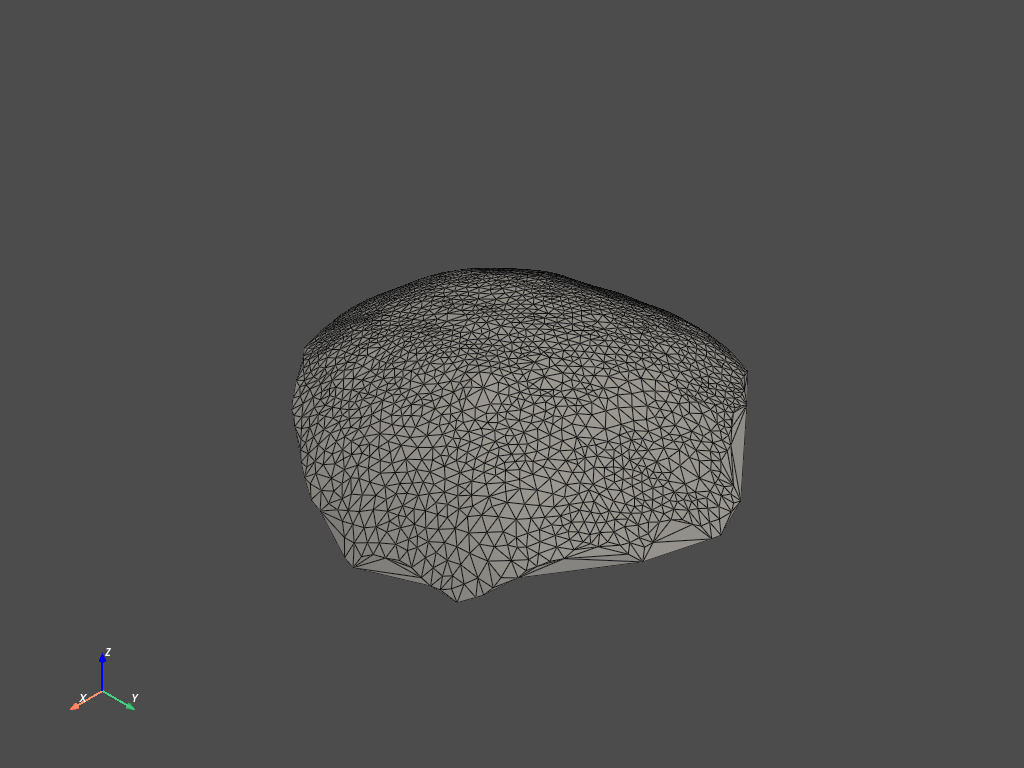

In [15]:
#1. Triangulate the surface
#source : https://docs.pyvista.org/examples/00-load/create-tri-surface.html

points = disc_df[["center_x", "center_y", "center_z"]].values
# simply pass the numpy points to the PolyData constructor
cloud = pv.PolyData(points)
surf = cloud.delaunay_2d()
surf.plot(show_edges=True, opacity = 0.5)

### Filter big edges

In [16]:
vertices = surf.points
faces = surf.faces
cells_df = pd.DataFrame(np.reshape(surf.faces, (-1,4)), columns = ["nb_points", "v1", "v2", "v3"])

In [17]:
def get_max_edge_length(row):
    def get_edge_length(a,b):
        [x0,y0,z0] = vertices[a,:]
        [x1,y1,z1] = vertices[b,:]
        return(np.sqrt((x0-x1)**2+(y0-y1)**2+(z0-z1)**2))
    len_12 = get_edge_length(row["v1"], row["v2"])
    len_23 = get_edge_length(row["v2"], row["v3"])
    len_31 = get_edge_length(row["v3"], row["v1"])
    return(max([len_12, len_23, len_31]))

cells_df["maximum_edge_length"] = cells_df[["v1", "v2", "v3"]].apply(get_max_edge_length ,axis = 1)
#think of a way to choose this threshold
len_thres = 0.1
cells_df["mask"] = cells_df.apply(lambda row: 1 if row["maximum_edge_length"]<len_thres else 0, axis = 1)
filtered_faces = cells_df.query("mask == 1")[["nb_points", "v1", "v2", "v3"]].values

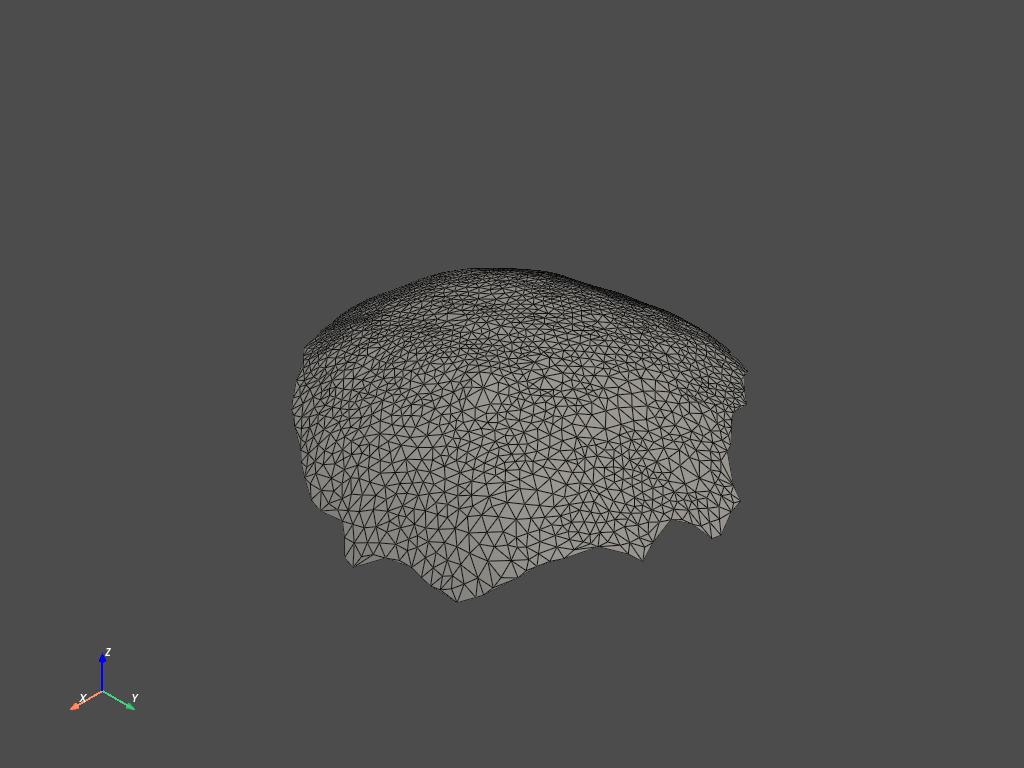

In [18]:
surf = pv.PolyData(vertices, filtered_faces)
surf.plot(show_edges=True, opacity = 0.5)

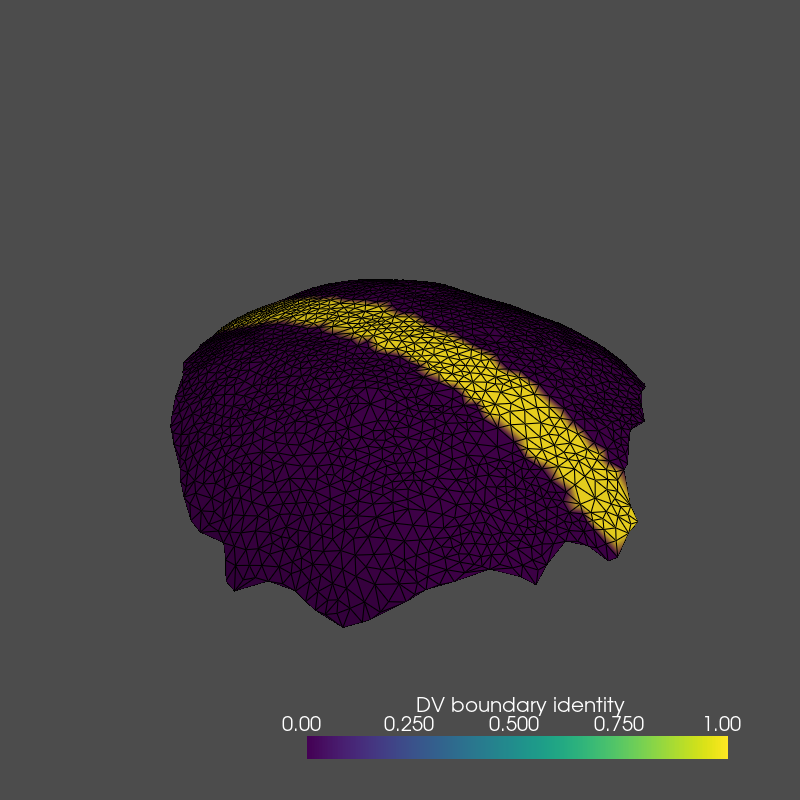

In [19]:
#2. Add $\underline{e}_R$, $\underline{e}_\phi$ and $\underline{e}_{h}$

#set vectors
surf["pos"] = disc_df[["center_x", "center_y", "center_z"]]
surf["e_R"] = -disc_df[["rHat_geom_inPlane_x", "rHat_geom_inPlane_y", "rHat_geom_inPlane_z"]].values
surf["e_h"] = disc_df[["normal_x", "normal_y", "normal_z"]].values
surf["e_phi"] = np.cross(surf["e_h"],surf["e_R"])
surf["DV_bool"] = np.where(disc_df["region"] == "DV", 1, 0)

#set scalars
scalar_cols = [#'area', 'mean_curvature', 'gaussian_curvature',
               #'k_fromDV','k_DV_pathlength','k_dist', 'k_dist_pathlength',
                'k_dist_pathlength_scaled',
               #'countInBin','cumcount'
              ]
for scalar in scalar_cols: surf[scalar] = disc_df[scalar].values

#source : https://docs.pyvista.org/examples/01-filter/glyphs.html
#source : https://docs.pyvista.org/api/plotting/_autosummary/pyvista.Plotter.add_mesh.html

plotter = pv.Plotter(window_size=[800,800])
#surf.set_active_scalars("k_dist_pathlength_scaled")
surf.set_active_scalars("DV_bool")
plotter.add_mesh(surf, show_edges=True,
                scalar_bar_args={'title': 'DV boundary identity'},
                 interpolate_before_map=False,
                )
plotter.show()

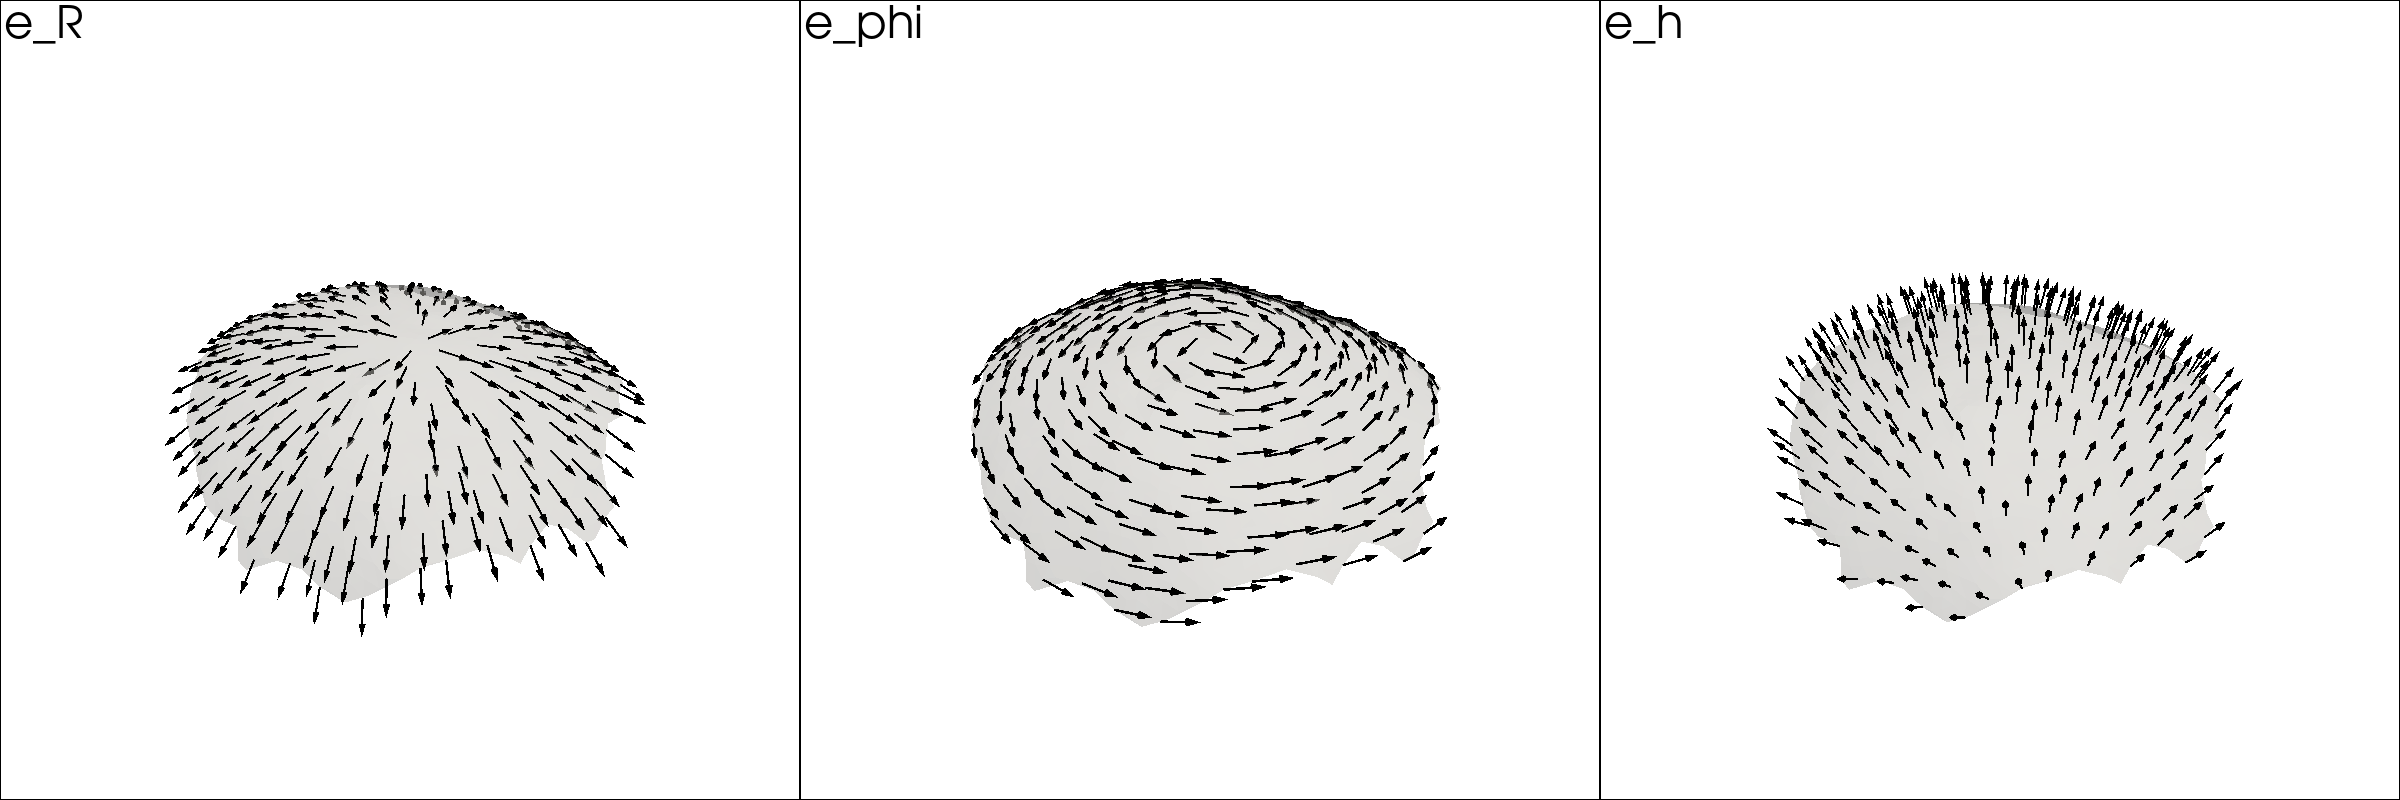

In [21]:
def helper_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 800, tolerance = 0.03):
    #display_args = dict(show_edges=True, color=True, line_width= 0.001)
    
    p = pv.Plotter(shape=vector_names.shape, window_size=[vector_names.shape[1]*window_scale, vector_names.shape[0]*window_scale])
    
    def single_plot(i,j,vector_name):
        p.subplot(i,j)
        if vector_name is None: 
            return p
        mesh["vector_scaled"] = mesh[vector_name]*scale_for_vis
        mesh.set_active_vectors("vector_scaled")
        arrows = mesh.glyph(scale="vector_scaled", orient="vector_scaled", tolerance=tolerance)
        p.add_mesh(arrows, lighting=False,show_scalar_bar=False, color = "black",)
        #p.add_mesh(surf.arrows, lighting=False,show_scalar_bar=False,)
        p.add_mesh(mesh, color="grey", ambient=0.6, opacity=0.5, show_edges=False)
        p.add_text(vector_name, color = "black")

    for i in range(vector_names.shape[0]):
        for j in range(vector_names.shape[1]):
            single_plot(i,j,vector_names[i,j])
            
    return p

vector_names = np.matrix([["e_R", "e_phi", "e_h"]])
plotter = helper_subplots(surf, vector_names)
plotter.background_color = "white"
plotter.show()


Defining $\underline{e}^{DV}_R$ and $\underline{e}^{DV}_\phi$ 


$\underline{e}_R^{DVc}  =\left(\underline{e}_h \cdot \underline{e}_R^{D V_c}\right) \underline{e}_h+A \underline{e}_R^{D V} $

$A \underline{e}_R^{D V}  =\underline{e}_R^{D V_c}-\left(\underline{e}_h \cdot \underline{e}_R^{D V_c}\right) \underline{e}_h $

$\underline{e}_R^{D V}  =\frac{\underline{e}_R^{D V_c}-\left(\underline{e}_h \cdot \underline{e}_R^{D V_c}\right)\underline{e}_h}{A} $

and 
$\underline{e}^{DV}_\phi = \underline{e}^{DV}_R \times \underline{e}_h$ 



In [22]:
#3. Compute $\underline{e}^{DV}_R$ and $\underline{e}^{DV}_\phi$ 
e_h = np.matrix(surf["e_h"])
e_h_dot_e_DVc_R = np.dot(e_h, e_DVc_R).T
e_DV_R = e_DVc_R - np.einsum('ij,ij->ij', e_h, e_h_dot_e_DVc_R) #not normalized
norm_inv = 1/np.linalg.norm(e_DV_R,axis=1)
e_DV_R = np.einsum('ij,i->ij', e_DV_R, norm_inv) #normalized
e_DV_phi = np.cross(e_DV_R, e_h)

surf["e_DV_R"] = e_DV_R
surf["e_DV_phi"] = e_DV_phi

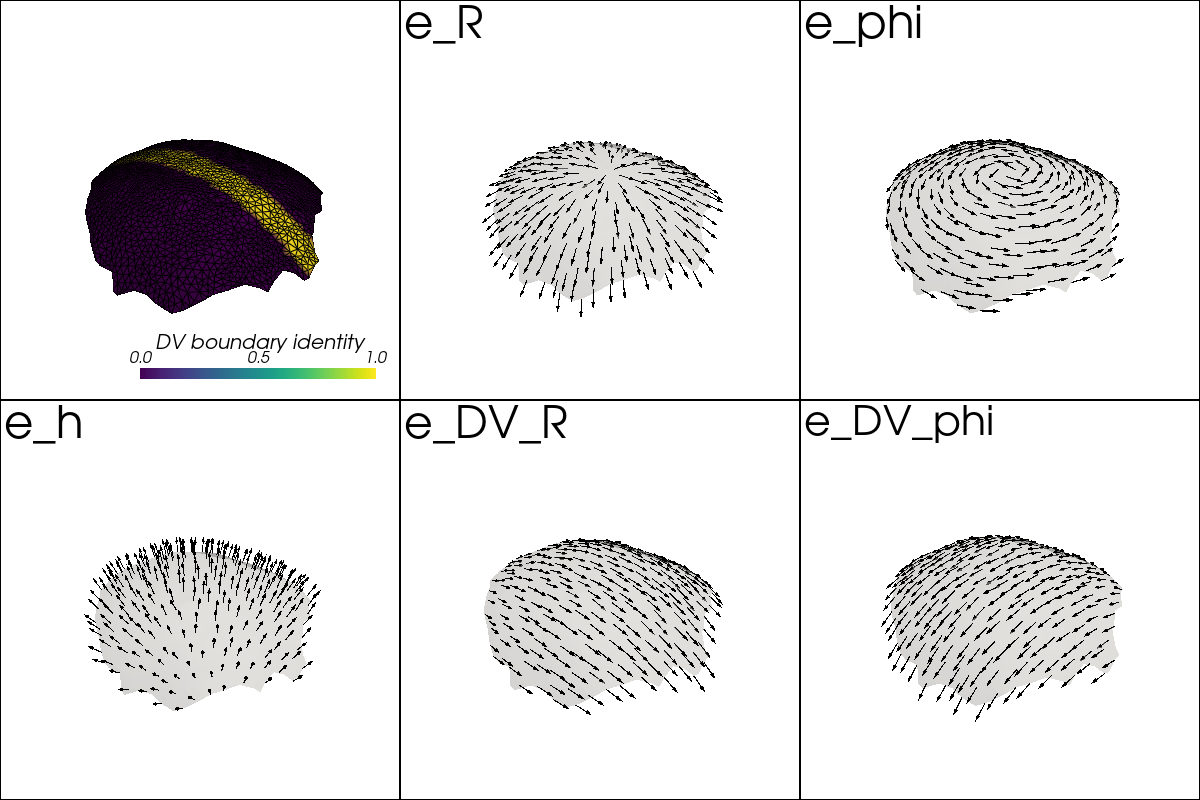

In [23]:
vector_names = np.matrix([[None, "e_R", "e_phi",],
                          ["e_h", "e_DV_R", "e_DV_phi"]
                         ])
plotter = helper_subplots(surf, vector_names, scale_for_vis= 0.1, window_scale = 400, tolerance = 0.03)

plotter.subplot(0,0)
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    background_color = "gray",
    color = "black",
    shadow=True,
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
    title = 'DV boundary identity',
)
surf.set_active_scalars("DV_bool")
plotter.add_mesh(surf, show_edges=True,scalar_bar_args=sargs,interpolate_before_map=False,)
plotter.background_color = "white"
plotter.show(screenshot='plots/test.png')


### Subdivide mesh

In [24]:
#surf = surf.subdivide(1, subfilter = 'loop')

In [25]:
cells_df

,nb_points,v1,v2,v3,maximum_edge_length,mask
0,3,206,180,28,0.036650,1
1,3,432,281,263,0.036483,1
2,3,859,551,553,0.040038,1
3,3,421,293,257,0.034789,1
4,3,210,190,14,0.035547,1
...,...,...,...,...,...,...
3383,3,1711,1707,1625,0.035450,1
3384,3,1712,1617,1623,0.047590,1
3385,3,1712,1623,1624,0.037277,1
3386,3,1713,1712,1624,0.031611,1


### Add thickness to mesh for simulation

In [26]:
#create a dataframe similar to balls and cells
cells_df = pd.DataFrame(np.reshape(surf.faces, (-1,4))[:,[1,2,3]], columns = ["v1", "v2", "v3"])
top_df = pd.DataFrame(surf.points, columns = ["x","y","z"])
#save e_h
top_df[["e_h_x", "e_h_y", "e_h_z"]] = surf["e_h"]
#save e_R
top_df[["e_R_x", "e_R_y", "e_R_z"]] = surf["e_R"]
#save e_phi
top_df[["e_phi_x", "e_phi_y", "e_phi_z"]] = surf["e_phi"]
#save e_DV_R
top_df[["e_DV_R_x", "e_DV_R_y", "e_DV_R_z"]] = surf["e_DV_R"]
#save e_DV_phi
top_df[["e_DV_phi_x", "e_DV_phi_y", "e_DV_phi_z"]] = surf["e_DV_phi"]
#save DV_bool
top_df["DV_bool"] = surf["DV_bool"]
#save p
top_df["pathlength_scaled"] = surf["k_dist_pathlength_scaled"]



#bottom_surf = surf.copy(deep=True)
#thickness = 6
#bottom_surf["orig_points"] = bottom_surf.points
#bottom_surf.points = bottom_surf.points - thickness*bottom_surf["normal"]
#bottom_df = pd.DataFrame(bottom_surf.points, columns = ["x","y","z"])

In [27]:
#function to add a bottom surface and join it to top surface

def add_thickness_to_mesh_arbitrary_surf(top_df=None, bottom_df = None, edges_df=None, cells_df = None, 
             thickness = 0.5, thickness_polynomial_obj = None,
             spring_const = 1, viscoelastic_coeff = 1,
             output_pickle = 'mesh_thick.pickle', output_vtk = 'foo_thick.vtk',
            ):
    
    if bottom_df is None:
        bottom_df = top_df.copy(deep = True)
        bottom_df[["x","y","z"]] = bottom_df[["x","y","z"]].values - (thickness*bottom_df[["e_h_x","e_h_y","e_h_z"]]).values
    
    if edges_df is None:
        #if edges_df is None then edges need to be extracted from cells_df
        cells = cells_df.values
        a1 = cells[:,[0,1]]
        a2 = cells[:,[1,2]]
        a3 = cells[:,[2,0]]
        redundant_edges_df = pd.DataFrame(np.vstack([a1,a2,a3]), columns=["v1", "v2"])
        G = nx.from_pandas_edgelist(redundant_edges_df, source = 'v1', target = 'v2').to_undirected()
        edges_df = nx.to_pandas_edgelist(G, source='v1', target='v2')
        

    if thickness_polynomial_obj is None:
        thickness_polynomial_obj = np.poly1d([thickness])

    balls_colnames=['ID', 'x', 'y', 'z', 'neighbours', 'spring1', 'spring2','stack']
    balls_colnames = balls_colnames + list(top_df.columns.drop(['x','y','z']))
    balls=pd.DataFrame(0, index=range(0), columns=range(len(balls_colnames)))
    balls.columns=balls_colnames
    balls.index = range(balls.shape[0])

    #dataframe of springs
    #ID, X1, Y1, Z1, X2, Y2, Z2, k, Natural length, Extension in length, Ball1, Ball2
    springs_colnames=['ID', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2',
                      'k', 'l0', 'l1','dl',
                      'ball1', 'ball2','type','viscoelastic_coeff']
    springs=pd.DataFrame(0, index=range(0), columns=range(len(springs_colnames)))
    springs.columns=springs_colnames

    nballs_per_stack = len(bottom_df)

    ############
    # Converting to df
    ###########
    
    nstack = 2
    nballs_per_stack = len(top_df)
    #thickness = 0.05
    #R = 1 - thickness
    #spring_const = 1
    #viscoelastic_coeff = 1

    ball_id = 0
    for stack in range(nstack):
        
        if stack == 0: v_df = bottom_df.copy(deep = True)
        if stack == 1: v_df = top_df.copy(deep = True)
            
        for i in range(nballs_per_stack):

            [x,y,z] = [v_df.iloc[i]['x'], v_df.iloc[i]['y'], v_df.iloc[i]['z'],]
            v_df_rest_values = list(v_df.iloc[i][v_df.columns.drop(['x','y','z'])])
            row = pd.DataFrame([[ball_id,x,y,z, [], [], [], stack] + v_df_rest_values], columns=balls_colnames)
            #print(row)
            balls = pd.concat([balls, row] , ignore_index = True)
            ball_id += 1

    #adding connections
    #for each point
    #    find particles which are neighbours according to edges_df
    #    To that list, add the same neighbours in the next stack
    #    Also add the same point in the next stack
    #    From this list select only particles which have id greater than the point
    #    get the coordinates of point as x1, y1, z1
    #    for each neighbour
    #        define spring id
    #        add id as spring1 for the point
    #        add id as spring2 for the neighbour
    #        add neighbour to list of neighbours of point
    #        add point to list of neighbours of this neighbour
    #        get the coordinates of neighbour as x2, y2, z2
    #        get the length of the spring
    #        check the type of spring (if the radius from center is same then it face otherwise it is edge)
    #        ball1 = point and ball2 = neighbour
    #        Add spring to the dataframe

    for i in range(len(balls)):

        point = i #id of ball - get id if the ids are not consecutive integers
        #get the list of neighbours according
        neighbours1 = np.array(edges_df.loc[(edges_df['v1'] == point%nballs_per_stack),'v2'].values) #here we take modulo of point because v and edges contain info about only one stack
        neighbours2 = np.array(edges_df.loc[(edges_df['v2'] == point%nballs_per_stack),'v1'].values) #here we take modulo of point because v and edges contain info about only one stack
        neighbours = np.concatenate([neighbours1, neighbours2, neighbours1 + nballs_per_stack, neighbours2 + nballs_per_stack, [(point%nballs_per_stack)+nballs_per_stack]])
        neighbours = np.unique(neighbours)
        neighbours = neighbours[(neighbours>point) & (neighbours<len(balls))]


        for neighbour in neighbours:


            if neighbour == point:
                #no self loop
                continue
            if( balls.loc[point, 'neighbours'].count(neighbour) > 0):
                #then this neighbour has already been connected
                continue

            balls.loc[point, 'neighbours'].append(neighbour)
            balls.loc[neighbour, 'neighbours'].append(point)


            spring_id = springs.shape[0]

            balls.loc[point, 'spring1'].append(spring_id)
            balls.loc[neighbour, 'spring2'].append(spring_id)


            length = np.sqrt(sum(np.square(balls.loc[point, ['x', 'y', 'z']].values -
                                           balls.loc[neighbour, ['x', 'y', 'z']].values)))

            if balls.loc[point,'stack'] == balls.loc[neighbour,'stack']:
                spring_type = 'inplane' #springs on the apical surface or basal surface
            else:
                spring_type = 'face' #pillars connecting the apical and basal

            row=pd.DataFrame([[spring_id] +
                              list(balls.loc[point, ['x', 'y', 'z']].values) +
                              list(balls.loc[neighbour, ['x', 'y', 'z']].values) +
                             [spring_const, length, length, 0, point, neighbour, spring_type, viscoelastic_coeff]])

            row.columns=springs.columns
            springs=pd.concat([springs,row])
            springs.index = range(springs.shape[0])



    dfToVtk(balls, springs, filename=output_vtk)

    pickle.dump([balls, springs], open(output_pickle, 'wb'))
    
    return([balls, springs])



In [28]:
%%time
thickness = 0.1
[balls,springs] = add_thickness_to_mesh_arbitrary_surf(top_df = top_df, cells_df = cells_df,
                                                       thickness = thickness, 
                                                       output_pickle = "pickle_files/"+disc+".pkl",
                                                       output_vtk = "thick_meshes/"+disc+".vtk",
                                                      )

CPU times: user 1min 21s, sys: 936 ms, total: 1min 22s
Wall time: 1min 23s
